## Modelo Hodgkin-Huxley de 3 dimensiones para células piramidales del CA1 del hipocampo 

### Herramientas de librerías 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', 'retina'}

In [2]:
import scipy as sc
from scipy import integrate
import numpy as np
from numba import njit

### Diccionario 

In [3]:
# Diccionario de parámetros 
p = {} # Diccionario vacío 
p['EK'] = -89.0 # Potencial de Nernst para el potasio K+
p['ENa']= 65.0 # Potencial de Nernst para el sodio Na+
p['ECa']= 128.0 # Potencial de Nernst para el calcio Ca+2
p['EL']= -58.0 # Potencial de Nernst para la corriente de fuga
p['ESyn']= 0.0 # potencial sináptico (0 para excitatoria)
p['gSyn']= 0.2 # conductancia sináptica
p['gK']= 60.0 # Conductancia del potasio K+
p['gK(Ca)']= 5.0 # Conductancia del potasio dependiente de calcio 
p['gNa']= 10.0 # Conductancia del sodio Na+
p['gCa']= 0.3 # Conductancia del calcio 
p['gL']= 0.01 # Conductancia de fuga

p['aMean'] = 35.0 # Media del proceso OU
p['aSD'] = 200.0 # Desviación estándar (amplitud del ruido)
p['tTau'] = 1.0/2.0
p['aTau'] = 10.0 # Constante de tiempo (inverso de reversión a la media)
p['vTCm'] = 1.0 # Factor de escala/normalización
p['useOU'] = True # Booleana para activar/desactivar el ruido OU

p['v12x']= 3.0
p['v12m']= -19.0 # Potencial de semi-activación para la corriente del sodio Na+
p['v12w']=-1.0 # Potencial de semi-activación para la corriente del potasio K+

p['mp']= 3 # Exponente de activación para canal de Na+
p['wp']= 4 # Exponente de activación para canal de K+
p['am']=0.054 # Control de la pendiente de la curva de activación para canales de Na+ (qué tan abruptamente se activan)
p['aw']=0.055 # Control de la pendiente de la curva de activación para canales de K+ (qué tan abruptamente se activan)
p['ax']= 0.2

p['alpha_syn']= 1.0
p['beta_syn']= 0.2
p['tau_syn']= 1.0
p['c_syn']= 1.0

p['lam']= 0.08 # Factor de escala para las pendientes de curvas de activación
p['taux'] = 1.0
p['Kp']= 3.0e-6 
p['Kd']= 7.4e-4
p['R']= 0.0045
p['usePulseTrain'] = True # Activar tren de pulsos
p['pulseAmp'] = 10.0 # Amplitud del pulso  
p['pulseRate'] = 0.2 # λ del Poisson 
p['upStart']=200.0 # Inicio de la fase de despolarización del estímulo de la corriente
p['upStop']=200.01 # Fin de la fase de despolarización del estímulo de corriente
p['dnStart']=1000.0 # Inicio de fase de repolarización del estímulo de corriente
p['dnStop']=1000.01 # Fin de fase de repolarización del estímulo de corriente
p['rampAmp']=0.0 # Amplitud del estímulo de corriente
p['s']= 1.0 # Factor de escala de las pendientes de las curvas de activación
p['Cm']=1.0 # Capacitancia membranal específica 
p['step'] = 0.001 # Paso de tiempo de la simulación 
p['tmin']= 0.0 # Tiempo mínimo de la simulación
p['tmax']= 1000.0 # Tiempo máximo de la simulación
p['sampTimes'] = np.arange(p['tmin'],p['tmax'],p['step']) # Arreglo de tiempo 
p['cmin'] = 0.0001

p['s0']=0.0
p['C0']=0.0
p['w0']=0.001 # Condición inicial de w, para activación de canales de K+ 
p['v0']=-70.0 # Condición inicial de v: potencial de equilibrio de la membrana (aproximadamente)
p['c0']=0.0001  # Condición inicial para la concentración de calcio
p['z0']= (p['v0'],p['w0'],p['c0'],p['s0'],p['C0']) # Condición inicial para las cuatro variables del sistema

### Función de inyección de corriente

In [4]:
def UpTopDn(t,upStart=200.0,upStop=400, dnStart=600.0,dnStop=800.0,rampAmp=1.0):
    slope_up = rampAmp/(upStop-upStart) # Pendiente de la recta de subida
                                        # Variar rampAmp nos daría qué tan sensible es al cambio la pendiente de recta de subida 
                                        # Variar upStop o upStart nos da la variación del cambio 
    int_up = -slope_up*upStart # Cálculo de b (la recta empieza en y=0)
                               # int_up cumple el papel de b
                               # Estamos en la parte inferior de la rampa
                               # Por ello la pendiente de subida y el incio de subida nos dan b
    slope_dn = -rampAmp/(dnStop-dnStart) # Pendiente de la recta de bajada
                                         # Ahora rampAmp nos da también la sensibilidad al cambip de la pendiente de bajada
                                         # Por ello ahora el inicio y término del descenso nos dan la variación del cambio
    int_dn= rampAmp-slope_dn*dnStart # Cálculo de b (la recta empieza en y=rampAmp)
                                     # Aquí int_dn hace el papel de b
                                     # Aquí estamos arriba de la rampa, por ello y=rampAmp
                                     # Por ello mismo la pendiente de bajada y el inicio de bajada nos dan b
    c1=np.int16((upStart<t)&(t<=upStop)) # Condición booleana para recta de subida
                                         # Es cuando el tiempo es mayor al tiempo de subida
                                         # Pero menor al tiempo de término subida
                                         # Por ello estamos subiendo
    c2=np.int16((upStop<t)&(t<=dnStart)) # Condición booleana para estancia en rampAmp
                                         # El tiempo ya superó el momento de detener subida 
                                         # Pero es menor al tiempo de iniciar bajada
                                         # Por ello nos mantenemos fijos en rampAmp 
    c3=np.int16((t>dnStart)&(t<=dnStop)) # Condición booleana para recta de bajada
                                         # Finalmente el tiempo superó el tiempo de iniciar bajada 
                                         # Pero es menor al tiempo de detener bajada
                                         # Es decir, ya estamos bajando para llegar otra vez al punto de inicio de la rampa
    y=c1*(slope_up*t +int_up)+ c2*rampAmp+ c3*(slope_dn*t +int_dn) # Recta resultante sometida a cada condición booleana
                                                                   # Dependiendo del tiempo, determinamos si estamos
                                                                   # Subiendo, fijos en rampAmp o bajando.
    return y # Justamente "y" es lo que sube, baja o se mantiene fijo  

In [5]:
def ouForcing_exact(p, seed=None): # Usamos seed para la reproducibilidad
    if seed is not None:
        np.random.seed(seed) # Así generamos la alateoridad necesaria 
    dt = p['step']
    t = np.arange(p['tmin'], p['tmax'], dt)
    n = t.size               # Nuestro vector de tiempo

    # Parámetros del proceso OU
    theta = 1.0 / p['aTau']  # parámetro de reversión a la media
    mu = p['aMean']  # media a largo plazo
    sigma = np.sqrt(2.0 * p['aSD'] * theta) # volatilidad

    # Términos de la solución exacta
    exp = np.exp(-theta * dt)
    variance = sigma * np.sqrt((1.0 - exp**2) / (2.0 * theta))
    noise = variance * np.random.randn(n-1)
    ou = np.empty(n)
    ou[0] = mu
    for i in range(1, n):
        ou[i] = mu + (ou[i-1] - mu) * exp + noise[i-1] # Resolvemos
    return ou / p['vTCm']

In [6]:
def random_pulse_train(t, rate=p['pulseRate'], amp=p['pulseAmp'], width=1.0, seed=None):
    if seed is not None:
        np.random.seed(seed)

    dt = t[1] - t[0]
    N = len(t)

    # tasa de pulsos tipo Poisson
    prob = rate * dt

    # generar pulsos
    pulses = np.zeros(N)
    pulse_centers = np.where(np.random.rand(N) < prob)[0]

    width_pts = int(width / dt)

    for c in pulse_centers:
        start = max(0, c)
        end = min(N, c + width_pts)
        pulses[start:end] += amp

    return pulses


### Ecuaciones diferenciales e integración de la corriente

In [7]:
def _integrate_numba(dt, tmax, save_every,
                     v0, w0, c0, s0, C0,
                     IStim, ouNoise,
                     gNa, ENa, mp,
                     gK, EK, wp,
                     gL, EL,
                     gCa, ECa,
                     gKCa, Kd,
                     s_scale,
                     am, aw, ax,
                     v12m, v12w, v12x,
                     lam, Kp, R, Cm,
                     alpha_syn, beta_syn, tau_syn,
                     c_syn, gSyn, ESyn,
                     pre_spikes):

    nsteps = int(tmax / dt)
    ns = nsteps // save_every + 1

    t_out = np.zeros(ns)
    v_out = np.zeros(ns)
    w_out = np.zeros(ns)
    c_out = np.zeros(ns)
    s_out = np.zeros(ns)
    C_out = np.zeros(ns)
    INa_out = np.zeros(ns)
    IK_out = np.zeros(ns)
    IL_out = np.zeros(ns)
    ICa_out = np.zeros(ns)
    IKCa_out = np.zeros(ns)
    Isyn_out = np.zeros(ns)
    ou_out = np.zeros(ns)
    
    v = v0
    w = w0
    c = c0
    s = s0
    C = C0
    
    j = 0

    for i in range(nsteps):
        t = i * dt
        
        # estímulo y OU
        Istim_now = IStim[i] if IStim is not None else 0.0
        ou_now = ouNoise[i] if (ouNoise is not None and ouNoise.size == nsteps) else 0.0
        
        C = C + dt * (-C / tau_syn) + c_syn * pre_spikes[i]
        #C = C + dt * (-C / tau_syn)

        winf = 1.0 / (1.0 + np.exp(-2.0 * aw * (v - v12w)))
        minf = 1.0 / (1.0 + np.exp(-2.0 * am * (v - v12m)))
        xinf = 1.0 / (1.0 + np.exp(-2.0 * ax * (v - v12x)))
        tauw = 1.0 / (lam * np.exp(aw * (v - v12w)) + lam * np.exp(-aw * (v - v12w)))

        INa  = gNa * (minf**mp)*(1-w) * (v - ENa)
        IK   = gK  * ((w)**wp) * (v - EK)
        IL   = gL * (v - EL)
        ICa  = gCa * xinf * (v - ECa)
        IKCa = gKCa * (c / (c + Kd)) * (v - EK)
        Isyn = gSyn * s * (v - ESyn)

        # din/dt 
        dvdt = (Istim_now + ou_now - INa - IK - IL - IKCa - ICa - Isyn) / Cm
        dwdt = (winf - w) / tauw
        dcdt = -Kp * ICa - R * c
        #dsdt = alpha_syn * (1.0 - s) * pre_spikes[i] - beta_syn * s
        dsdt = alpha_syn * (1.0 - s) * C - beta_syn * s

        v = v + dt * dvdt
        w = w + dt * dwdt
        c = c + dt * dcdt
        s = s + dt * dsdt

        if (i % save_every) == 0:
            t_out[j] = t
            v_out[j] = v
            w_out[j] = w
            c_out[j] = c
            s_out[j] = s
            C_out[j] = C
            INa_out[j] = INa
            IK_out[j] = IK
            IL_out[j] = IL
            ICa_out[j] = ICa
            IKCa_out[j] = IKCa
            Isyn_out[j] = Isyn
            ou_out[j] = ou_now
            
            j += 1


    return (t_out, v_out, w_out, c_out, s_out, C_out,
            INa_out, IK_out, IL_out, ICa_out, IKCa_out, Isyn_out, ou_out)

### Simulación

In [8]:
def simulateHH_numba(p, save_every=10, seed=None):
    
    # Genera OU 
    if p.get('useOU', False) and 'ouNoise' not in p:
        p['ouNoise'] = ouForcing_exact(p, seed=seed)

    # Tiempos
    times_full = np.arange(p['tmin'], p['tmax'], p['step'])   # todos los pasos
    times_save = times_full[::save_every]                     # pasos que sí se guardan

    if p.get('usePulseTrain', False):
        pulse_train = random_pulse_train(
            times_full,
            rate=p['pulseRate'],
            amp=p['pulseAmp'],
            width=1.0,
            seed=seed)
        pre_spikes = (pulse_train > 0).astype(np.int32)
    else:
        pulse_train = np.zeros_like(times_full)
        pre_spikes = np.zeros_like(times_full, dtype=np.int32)

    # Estímulo vectorizado 
    def jStim_vec(times, p):
        out = np.zeros_like(times)
        for i in range(times.size):
            out[i] = UpTopDn(times[i], upStart=p['upStart'], upStop=p['upStop'],
                             dnStart=p['dnStart'], dnStop=p['dnStop'],
                             rampAmp=p['rampAmp'])
        return out
        
    IStim_full = np.zeros_like(times_full)

    IStim_full = IStim_full + pulse_train
    
    # Estímulo determinista
    IStim_full = jStim_vec(times_full, p)

    # Tren de pulsos aleatorios
    if p.get('usePulseTrain', False):
        IStim_full = IStim_full + pulse_train
        
    IStim_save = IStim_full[::save_every]

    # Lo mismo para OU
    if p.get('useOU', False):
        ouNoise_save = p['ouNoise'][::save_every]
    else:
        ouNoise_save = np.zeros_like(times_save)

    # Parámetros convertidos a float 
    gNa = float(p['gNa']); ENa = float(p['ENa']); mp = float(p['mp'])
    gK = float(p['gK']); EK = float(p['EK']); wp = float(p['wp'])
    gL = float(p['gL']); EL = float(p['EL'])
    gCa = float(p['gCa']); ECa = float(p['ECa'])
    gKCa = float(p['gK(Ca)']); Kd = float(p['Kd'])
    gsyn = float(p['gSyn']); Esyn = float(p['ESyn'])

    am = float(p['am']); aw = float(p['aw']); ax = float(p['ax'])
    v12m = float(p['v12m']); v12w = float(p['v12w']); v12x = float(p['v12x'])
    lam = float(p['lam'])
    s_scale = float(p['s'])
    Kp = float(p['Kp']); R = float(p['R']); 
    Cm = float(p['Cm'])

    v0 = float(p.get('v0', -70.0))
    w0 = float(p.get('w0', 0.001))
    c0 = float(p.get('c0', 0.0001))
    s0 = float(p.get('s0', 0.0))
    C0 = float(p.get('C0', 0.0))

    # solver
    (
        t_out, v_out, w_out, c_out, s_out, C_out,
        INa_out, IK_out, IL_out, ICa_out, IKCa_out, Isyn_out, ou_out
    ) = _integrate_numba(
        p['step'], p['tmax'], save_every,
        v0, w0, c0, s0, C0, IStim_full, 
        p['ouNoise'] if p.get('useOU') else np.zeros_like(IStim_full),
        gNa, ENa, mp, gK, EK, wp, gL, EL,
        gCa, ECa, gKCa, Kd, s_scale,
        am, aw, ax, v12m, v12w, v12x, lam,
        Kp, R, Cm, p['alpha_syn'], p['beta_syn'], p['tau_syn'],
        p['c_syn'], p['gSyn'], p['ESyn'], pre_spikes
    )

    # Alineación automática de tamaños
    minN = min(len(t_out), len(IStim_save))
    
    t_out    = t_out[:minN]
    v_out    = v_out[:minN]
    w_out    = w_out[:minN]
    c_out    = c_out[:minN]
    s_out    = s_out[:minN]
    C_out    = C_out[:minN]
    INa_out  = INa_out[:minN]
    IK_out   = IK_out[:minN]
    IL_out   = IL_out[:minN]
    ICa_out  = ICa_out[:minN]
    IKCa_out = IKCa_out[:minN]
    Isyn_out  = Isyn_out[:minN]
    ou_out   = ou_out[:minN]
    
    IStim_save   = IStim_save[:minN]
    ouNoise_save = ouNoise_save[:minN]
    
    # Ensamble
    N = t_out.size

    xx = {'v': v_out, 'w': w_out, 'c': c_out, 's': s_out, 'C': C_out, 'sampTimes': t_out, 'IStim': IStim_save, 'INa': INa_out,
        'IK': IK_out, 'IL': IL_out, 'ICa': ICa_out, 'IKCa': IKCa_out, 'Isyn': Isyn_out,  'ouNoise': ouNoise_save
    }

    # Graficación
    ax1=list()
    fig1 = plt.figure(figsize=(12,8))
    plt.ioff()
    
    rows = 6; cols = 1

    plt.subplot(rows,cols,1)
    plt.plot(xx['sampTimes'], xx['v'], 'k')
    plt.xlim(0, p['tmax'])
    plt.ylim(-150, 100)
    plt.ylabel(r'$v$ (mV)')
    plt.grid()

    plt.subplot(rows,cols,2)
    plt.plot(xx['sampTimes'], xx['IStim'], 'k')
    plt.xlim(0, p['tmax'])
    plt.ylim(0,160)
    plt.ylabel(r'$I_{Stim}$(pA)')
    plt.grid()

    plt.subplot(rows,cols,3)
    if p['useOU']:
        plt.plot(xx['sampTimes'], xx['ouNoise'], 'r', alpha=0.7)
        plt.ylabel('OU Noise')
        plt.ylim(-3*p['aSD']/p['vTCm'], 3*p['aSD']/p['vTCm'])
    else:
        plt.text(0.5, 0.5, 'OU Noise Disabled', transform=plt.gca().transAxes,
                 ha='center', va='center')
    plt.grid()

    plt.subplot(rows,cols,4)
    plt.plot(xx['sampTimes'], xx['c'], 'y')
    plt.xlim(0, p['tmax'])
    plt.ylabel(r'$Ca$ (μM)')
    plt.grid()

    plt.subplot(rows,cols,5)
    plt.plot(xx['sampTimes'], xx['s'], 'm')
    plt.xlim(0, p['tmax'])
    plt.ylabel(r'$s$')
    plt.grid()

    plt.subplot(rows,cols,6)
    plt.plot(xx['sampTimes'], xx['C'], 'y')
    plt.xlim(0, p['tmax'])
    plt.ylabel(r'$C$ (μM)')
    plt.grid()

    plt.ion(); plt.draw(); plt.show()

    return xx


### Para graficar un sólo potencial de acción y sus respectivas corrientes

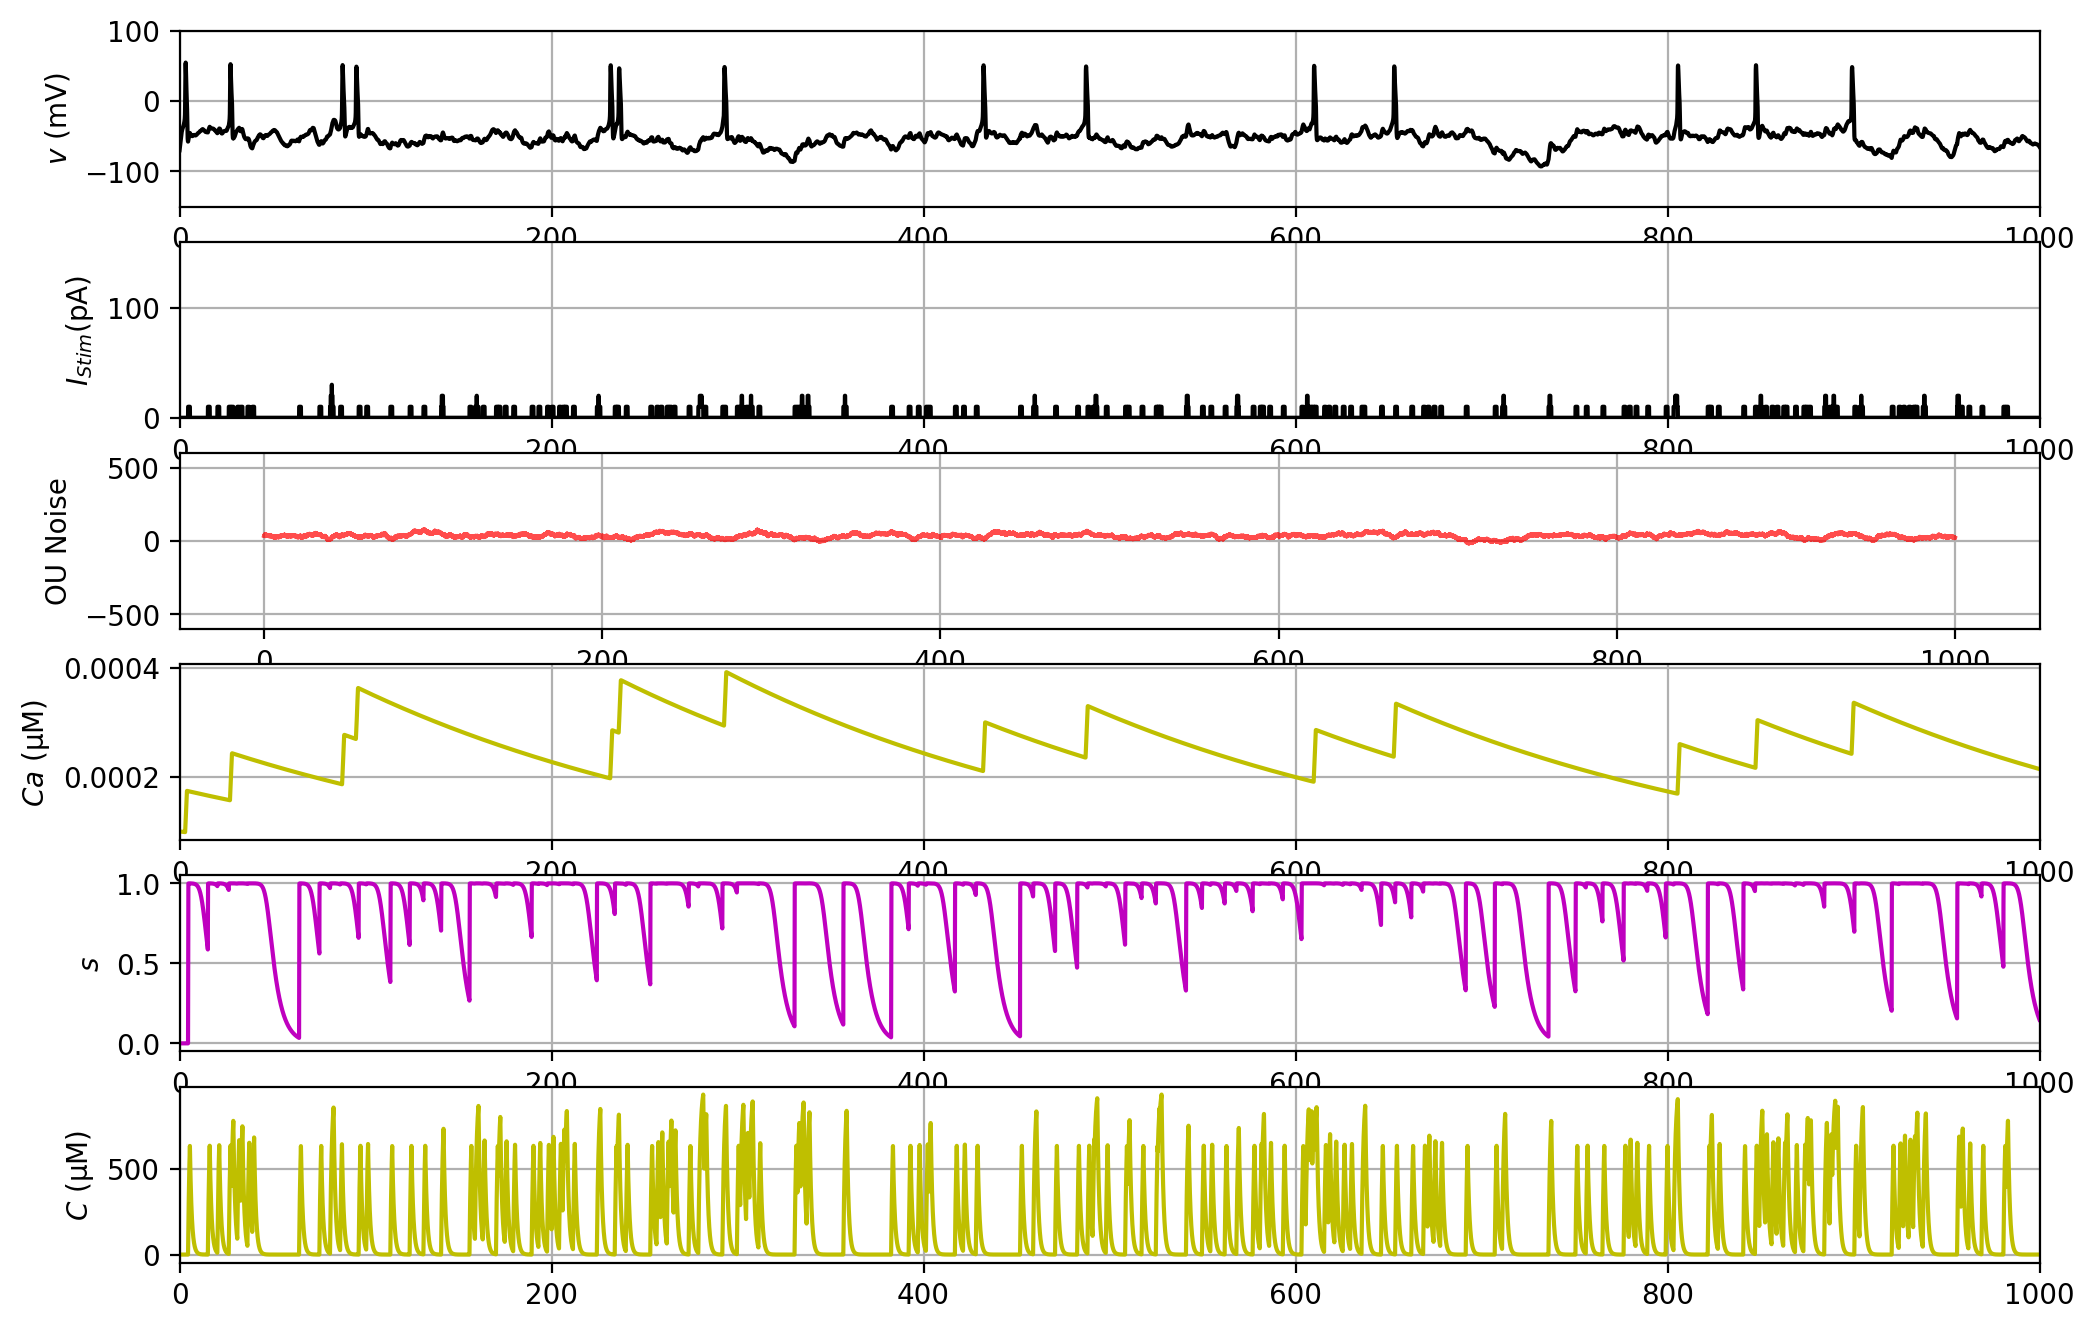

In [9]:
xx = simulateHH_numba(p)

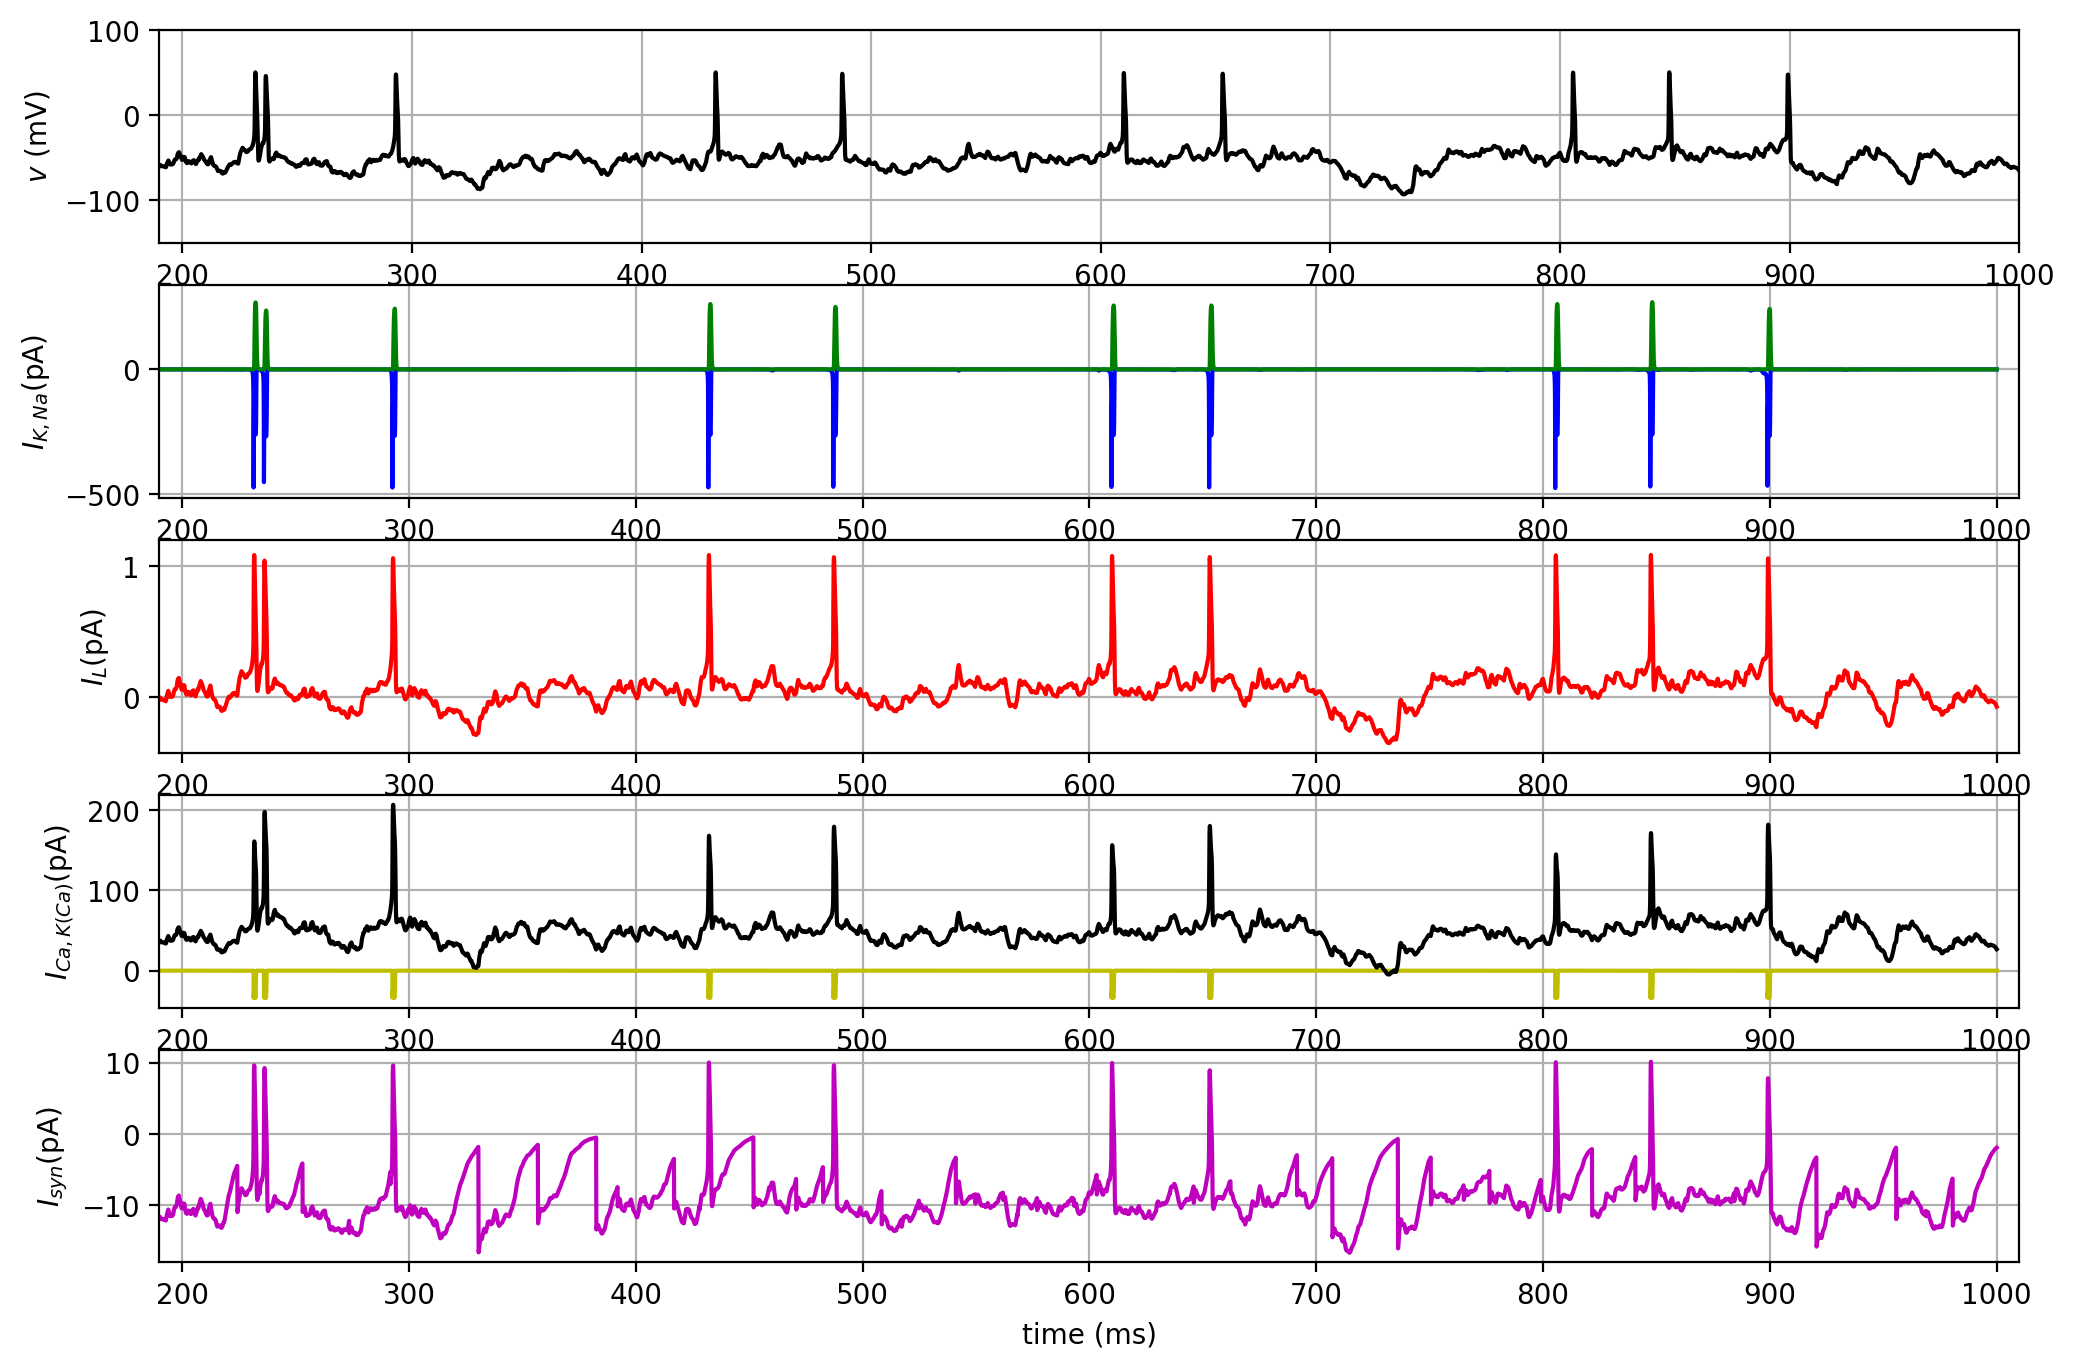

In [10]:
ax1=list()
fig1=plt.figure(figsize=(12,8)) # Configuramos detalles de la gráfica 
plt.ioff()

rows = 5; cols=1;

plt.subplot(rows,cols, 1)
plt.plot(xx['sampTimes'], xx['v'], 'k')
plt.ylim(-150,100)
plt.xlim(190,1000)
plt.ylabel(r'$v$ (mV)')
plt.grid() # Aquí graficamos potencial de membrana, es decir, potencial en el tiempo y así podemos ver
           # la forma completa del potencial de acción

plt.subplot(rows,cols, 2)
plt.plot(xx['sampTimes'], xx['INa'], 'b') # Corriente de sodio la mandamos azul 
plt.plot(xx['sampTimes'], xx['IK'], 'g')  # Corriente de potasio la mandamos verde
plt.xlim(190,1010)
plt.ylabel(r'$I_{K,Na}$(pA)')
plt.xlabel(r'time (ms)')
plt.grid() # Y graficamos 

plt.subplot(rows,cols, 3)
plt.plot(xx['sampTimes'], xx['IL'], 'r') # Finalmente mandamos la corriente de fuga con color rojo
plt.xlim(190,1010)
plt.ylabel(r'$I_{L}$(pA)')
plt.xlabel(r'time (ms)')
plt.grid() # Y graficamos 

plt.subplot(rows,cols, 4)
plt.plot(xx['sampTimes'], xx['ICa'], 'y')
plt.plot(xx['sampTimes'], xx['IKCa'], 'k')
plt.xlim(190,1010)
plt.ylabel(r'$I_{Ca,K(Ca)}$(pA)')
plt.xlabel(r'time (ms)')
plt.grid() # Y graficamos 

plt.subplot(rows,cols, 5)
plt.plot(xx['sampTimes'], xx['Isyn'], 'm') 
plt.xlim(190,1010)
plt.ylabel(r'$I_{syn}$(pA)')
plt.xlabel(r'time (ms)')
plt.grid() # Y graficamos 

plt.ion(); plt.draw(); plt.show()